# Organization 

Multiple Jupyter notebooks for Harvard and Duke Forest 

Harvard Forest: 
1. Literature Review 
2. Data cleaning 
3. Linking the tags plant species 
4. Data exploration 
5. Feature engineering and extraction 
6. Modeling (Supervised, Unsupervised...) 
7. Analysis - Parametric and Non-parametric 
7. Conclusions 

Features:

hf199-01: hf environment

year: year
month: month
day: day of month
time: hour of day
chamber: chamber number (1-12)
treatment: light treatment
G: chamber in open gap
S: chamber under closed canopy
warming: warming treatment
3: 3 degrees C
5: 5 degrees C
A: ambient
C: control
AT: air temperature (unit: celsius / missing value: NA)
Q: photosynthetically active radiation (unit: micromolePerMeterSquaredPerSecond / missing value: NA)
Rh: relative humidity (%) (unit: dimensionless / missing value: NA)
SM: volumetric water content (fractional) (unit: dimensionless / missing value: NA)
ST: soil temperature at 5cm depth (unit: celsius / missing value: NA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
sns.set(style="ticks", color_codes=True)

import chardet
import codecs

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

import folium
from folium import plugins
from scipy import stats

%matplotlib inline
plt.style.use('seaborn-white')

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Loading the data again.


df = pd.read_csv('/Users/mille/Desktop/Final Capstone/hf199-04-df-env.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)


# providing more information per column on data types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (750768, 14)


,year,times,month,day,JD,JD2009,dayFraction,chamber,treatment,AT,Q,Rh,SM,ST
column type,int64,float64,int64,int64,int64,int64,float64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,0,0,0,77654,158106,750768,162,77614
null values (%),0,0,0,0,0,0,0,0,0,10.3433,21.0592,100,0.0215779,10.3379


## Data cleaning 

In [3]:
# Calculate total number of cells in dataframe
totalCells = np.product(df.shape)

# Count number of missing values per column
missingCount = df.isnull().sum()

# Calculate total number of missing values
totalMissing = missingCount.sum()

# Calculate percentage of missing values
print("The Harvard Forest dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

The Harvard Forest dataset contains 10.13 % missing values.


In [4]:
missingCount[['year','month', 'day', 'hour', 'chamber', 'treatment', 'warming', 'AT', 'Q', 'Rh', 'SM', 'ST']]



year              0.0
month             0.0
dayhour           NaN
chamber           0.0
treatment         0.0
warming           NaN
AT            77654.0
Q            158106.0
Rh           750768.0
SM              162.0
ST            77614.0
dtype: float64

In [5]:
print("Percent missing data in SM column =", (round(((missingCount['SM'] / df.shape[0]) * 100), 2)))
print("Percent missing data in Rh column =", (round(((missingCount['Rh'] / df.shape[0]) * 100), 2)))
print("Percent missing data in AT column =", (round(((missingCount['AT'] / df.shape[0]) * 100), 2)))
print("Percent missing data in Q column =", (round(((missingCount['Q'] / df.shape[0]) * 100), 2)))
print("Percent missing data in ST column =", (round(((missingCount['ST'] / df.shape[0]) * 100), 2)))


Percent missing data in SM column = 0.02
Percent missing data in Rh column = 100.0
Percent missing data in AT column = 10.34
Percent missing data in Q column = 21.06
Percent missing data in ST column = 10.34


In [6]:
df_dropna = df.dropna()
df_dropna.head(5)

,year,times,month,day,JD,JD2009,dayFraction,chamber,treatment,AT,Q,Rh,SM,ST


In [7]:
df_CleanCols = df.dropna(axis=1)
df_CleanCols.head()

,year,times,month,day,JD,JD2009,dayFraction,chamber,treatment
0,2009,125.54,5,6,-240,125,0.54,1,G
1,2009,125.54,5,6,-240,125,0.54,2,G
2,2009,125.54,5,6,-240,125,0.54,3,G
3,2009,125.54,5,6,-240,125,0.54,4,G
4,2009,125.54,5,6,-240,125,0.54,5,G


In [8]:
print("Columns in original dataset: %d \n" % df.shape[1])
print("Columns with na's dropped: %d" % df_CleanCols.shape[1])

Columns in original dataset: 14 

Columns with na's dropped: 9


In [9]:
use_df = df.fillna(method='ffill', axis=0).fillna("0")

use_df.head()

,year,times,month,day,JD,JD2009,dayFraction,chamber,treatment,AT,Q,Rh,SM,ST
0,2009,125.54,5,6,-240,125,0.54,1,G,24.226667,450.6,0,0.239,21.036667
1,2009,125.54,5,6,-240,125,0.54,2,G,24.513333,502.7,0,0.232,20.866667
2,2009,125.54,5,6,-240,125,0.54,3,G,24.070000,416.9,0,0.262,19.590000
3,2009,125.54,5,6,-240,125,0.54,4,G,24.443333,526.2,0,0.237,20.415000
4,2009,125.54,5,6,-240,125,0.54,5,G,24.305000,385.0,0,0.212,19.655000


In [10]:
use_df.dtypes

year             int64
times          float64
month            int64
day              int64
JD               int64
JD2009           int64
dayFraction    float64
chamber          int64
treatment       object
AT             float64
Q              float64
Rh              object
SM             float64
ST             float64
dtype: object

## Converting light 'treatment' to binary 

treatment: light treatment
G: chamber in open gap = 0
S: chamber under closed canopy = 1

In [11]:
use_df['treatment'] = use_df['treatment'].apply({ 'G': 0, 'S': 1}.get)

## Converting 'warming treatment' to classes

warming: warming treatment

C - control = 0
A - ambient = 1
3 - degrees C = 2
5 - degrees C = 3

In [13]:
use_df.head(10)

,year,times,month,day,JD,JD2009,dayFraction,chamber,treatment,AT,Q,Rh,SM,ST
0,2009,125.54,5,6,-240,125,0.54,1,0,24.226667,450.6,0,0.239,21.036667
1,2009,125.54,5,6,-240,125,0.54,2,0,24.513333,502.7,0,0.232,20.866667
2,2009,125.54,5,6,-240,125,0.54,3,0,24.070000,416.9,0,0.262,19.590000
3,2009,125.54,5,6,-240,125,0.54,4,0,24.443333,526.2,0,0.237,20.415000
4,2009,125.54,5,6,-240,125,0.54,5,0,24.305000,385.0,0,0.212,19.655000
5,2009,125.54,5,6,-240,125,0.54,6,0,24.280000,385.0,0,0.212,20.180000
6,2009,125.54,5,6,-240,125,0.54,7,0,23.865000,398.5,0,0.204,20.963333
7,2009,125.54,5,6,-240,125,0.54,8,0,23.760000,331.2,0,0.215,20.135000
8,2009,125.54,5,6,-240,125,0.54,9,0,24.175000,401.8,0,0.235,21.135000
9,2009,125.54,5,6,-240,125,0.54,10,0,24.175000,401.8,0,0.246,21.135000


In [14]:
use_df.dtypes

year             int64
times          float64
month            int64
day              int64
JD               int64
JD2009           int64
dayFraction    float64
chamber          int64
treatment        int64
AT             float64
Q              float64
Rh              object
SM             float64
ST             float64
dtype: object

In [15]:
use_df["Q"] = use_df.Q.convert_objects(convert_numeric=True)

use_df["Rh"] = use_df.Rh.convert_objects(convert_numeric=True)


In [16]:
use_df.dtypes

year             int64
times          float64
month            int64
day              int64
JD               int64
JD2009           int64
dayFraction    float64
chamber          int64
treatment        int64
AT             float64
Q              float64
Rh               int64
SM             float64
ST             float64
dtype: object

In [17]:
# Evenly distributed light treatments 
use_df['treatment'].value_counts()



1    375384
0    375384
Name: treatment, dtype: int64

In [18]:
#Just continious features 
cont_data=use_df.loc[:,'AT':'ST']

#All binary features
binary_data=use_df['treatment']



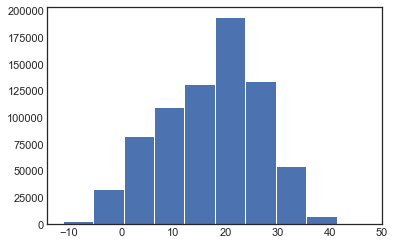

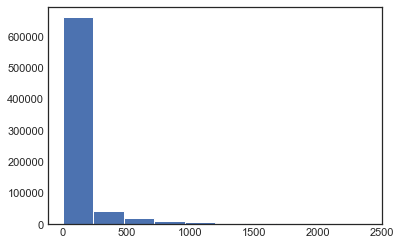

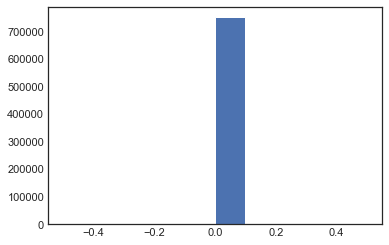

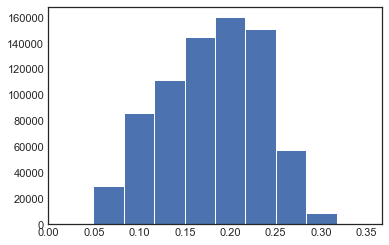

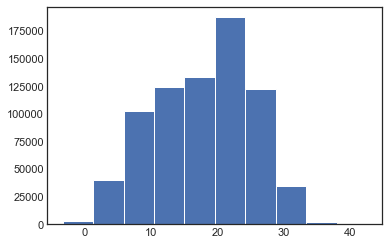

In [19]:
for i, col in enumerate(cont_data.columns):
    plt.figure(i)
    plt.hist(cont_data[col])

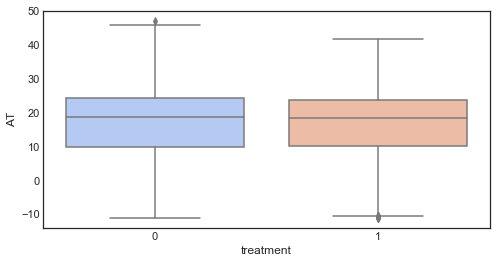

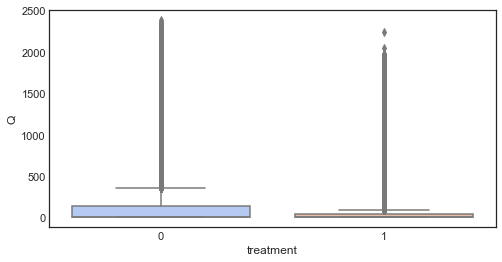

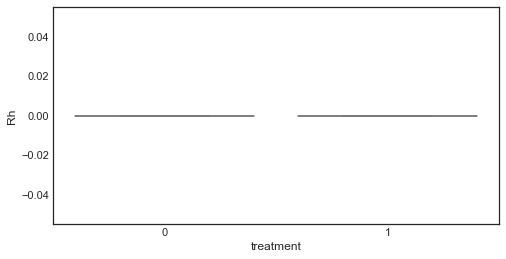

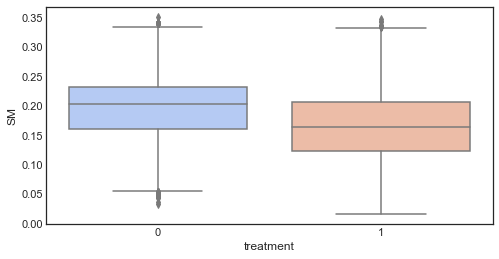

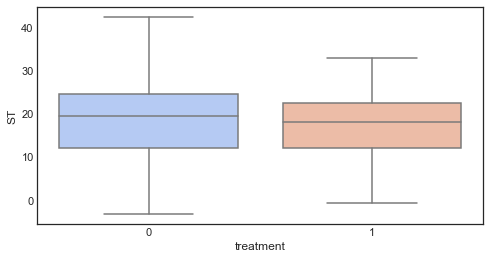

In [20]:
use_df['treatment']=use_df['treatment'].astype('category') #To convert target class into category

for i, col in enumerate(cont_data.columns):
    plt.figure(i,figsize=(8,4))
    sns.boxplot(x=use_df['treatment'], y=col, data=use_df, palette="coolwarm")

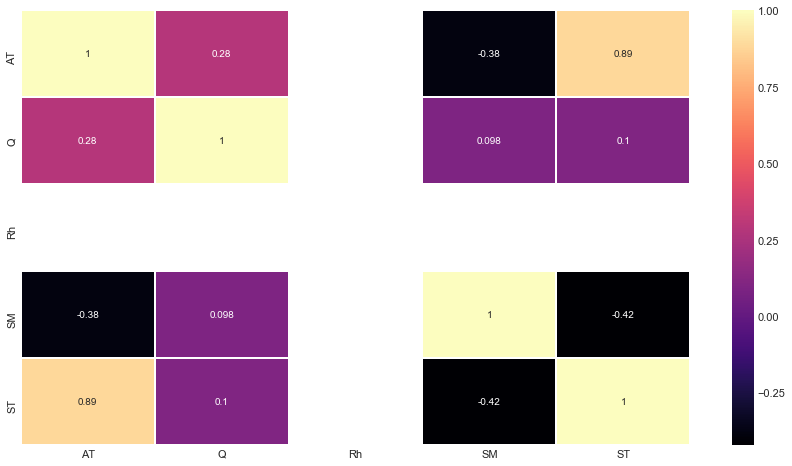

In [21]:
plt.figure(figsize=(15,8))
sns.heatmap(cont_data.corr(),cmap='magma',linecolor='white',linewidths=1,annot=True)

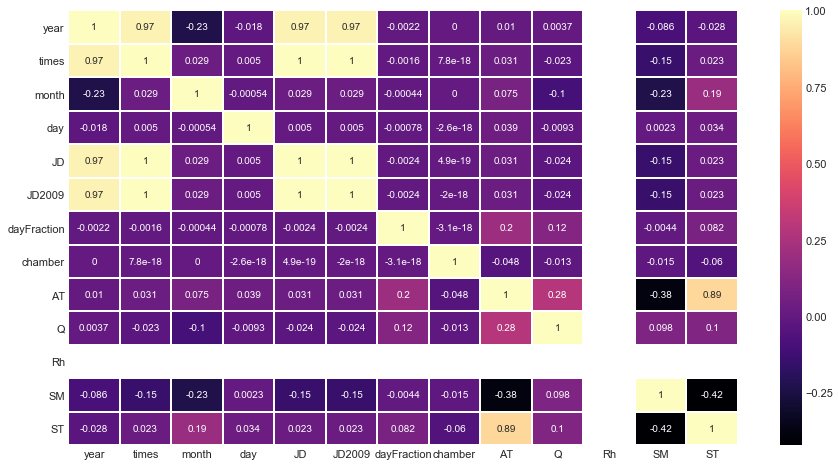

In [22]:
plt.figure(figsize=(15,8))
sns.heatmap(use_df.corr(),cmap='magma',linecolor='white',linewidths=1,annot=True)

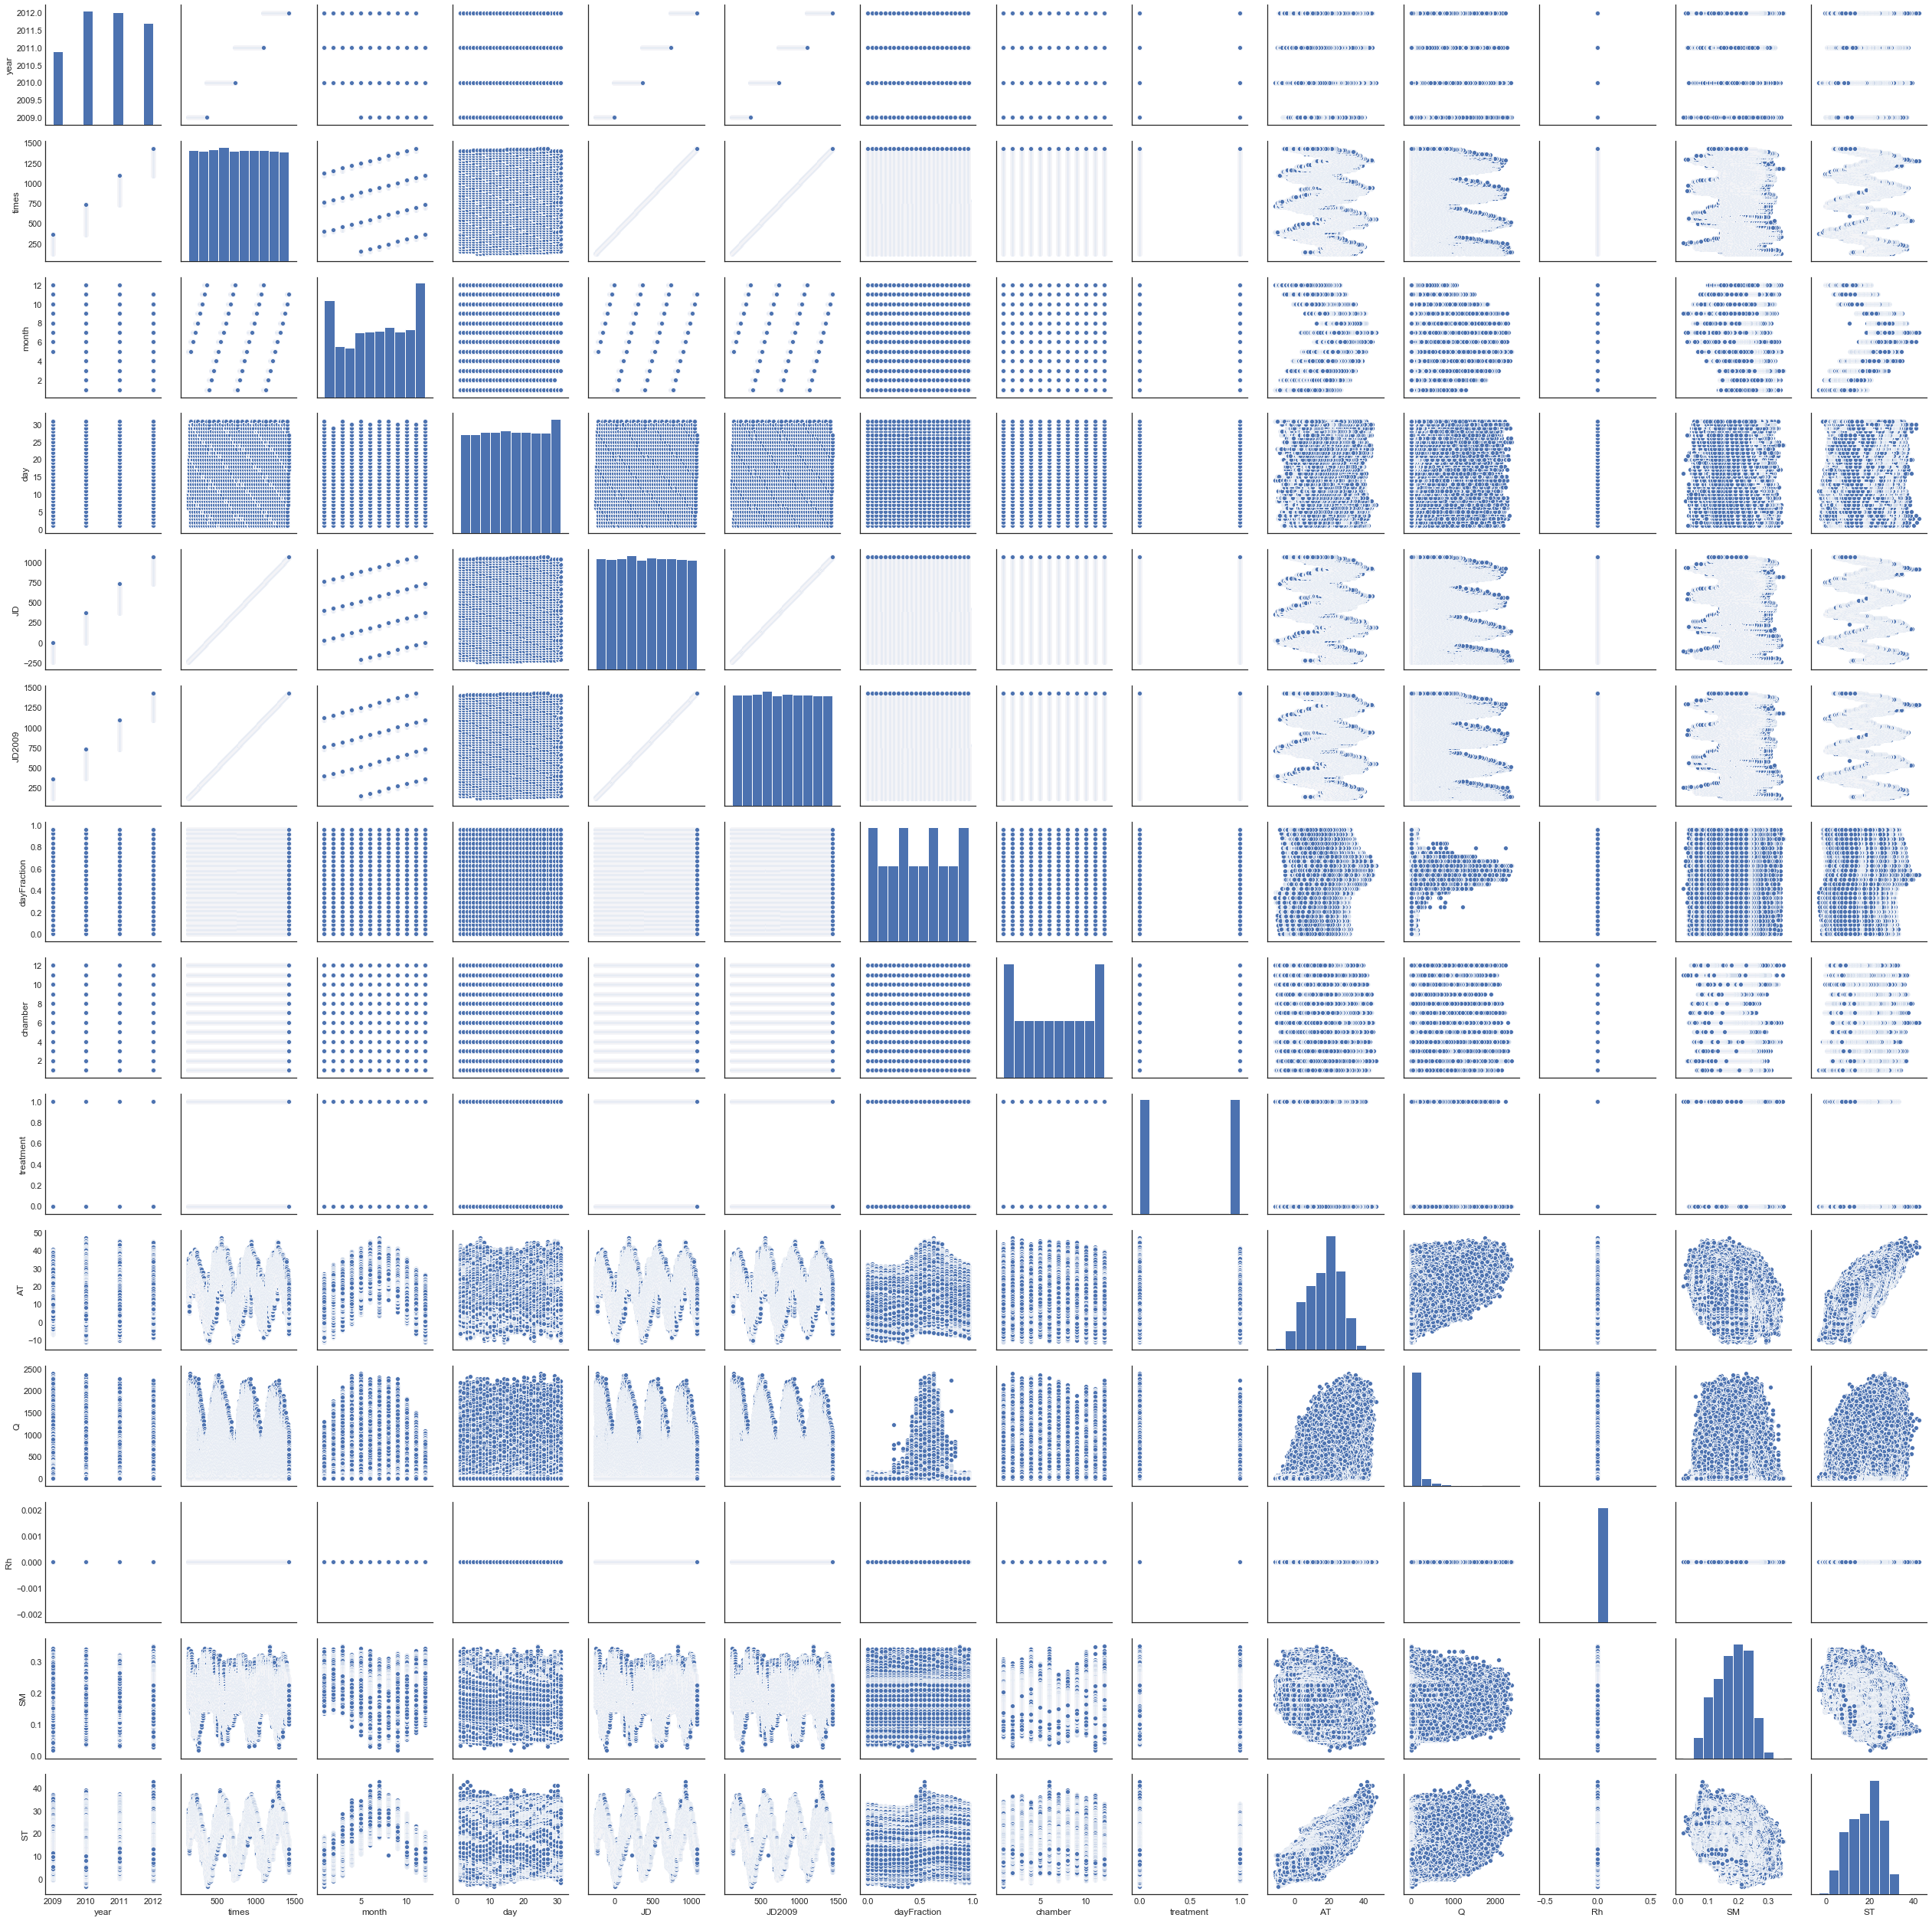

In [23]:
g = sns.pairplot(use_df)

# Supervised Machine Learning models 



In [24]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

## Logistic Regression 

In [25]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [26]:
from sklearn.model_selection import train_test_split

In [28]:
X = use_df.ix[:, 'AT':'ST']
y = use_df['treatment']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
predictions = logmodel.predict(X_test)

In [33]:
from sklearn.metrics import classification_report

In [34]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.69      0.66      0.67    123779
           1       0.67      0.70      0.69    123975

   micro avg       0.68      0.68      0.68    247754
   macro avg       0.68      0.68      0.68    247754
weighted avg       0.68      0.68      0.68    247754



In [35]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [36]:
# Build the k-fold cross-validator

kfold = KFold(n_splits=7, random_state=42)

In [37]:
result = cross_val_score(logmodel, X, y, cv=kfold, scoring='accuracy')
print(result.mean())

0.6733825079303453


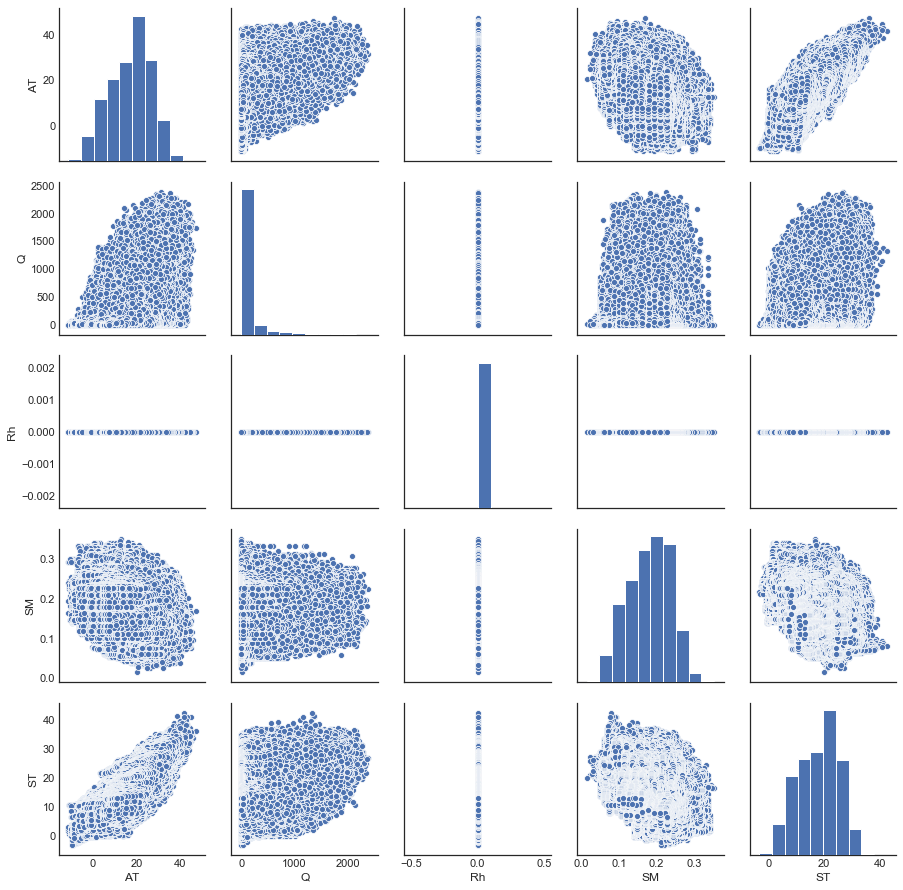

In [38]:
sns.pairplot(use_df[['AT', 'Q', 'Rh', 'SM', 'ST']])

## Naive Bayes 

In [39]:
data = use_df.ix[:, 'AT':'ST']
target = use_df['treatment']

In [40]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
y_pred = bnb.fit(data, target).predict(data)

In [41]:
# Test your model with different holdout groups.

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.5251008964130159
Testing on Sample: 0.5234626409223622


In [42]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix

In [43]:
f1_score(target, y_pred, average='macro')  


0.5001505480127147

In [44]:
print(classification_report(target, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.31      0.39    375384
           1       0.52      0.74      0.61    375384

   micro avg       0.52      0.52      0.52    750768
   macro avg       0.53      0.52      0.50    750768
weighted avg       0.53      0.52      0.50    750768



In [45]:
#Supervised Learning imports 

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Random Forest 

In [48]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

X = use_df.ix[:, 'AT':'ST']
Y = use_df['treatment']

rfc = ensemble.RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.1,random_state=0)
train = rfc.fit(X_train, y_train)

rfc.fit(X_train, y_train)

# Apply to testing data
y_hat = rfc.predict(X_test)


print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))
print(classification_report(y_test, y_hat))


Training set score: 0.9882594262762121

Test set score: 0.7930924251102202
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     37381
           1       0.82      0.76      0.79     37696

   micro avg       0.79      0.79      0.79     75077
   macro avg       0.79      0.79      0.79     75077
weighted avg       0.79      0.79      0.79     75077

